In [50]:
%load_ext autoreload
%autoreload 2
import os
#change current working directory to the parent directory
if 'changed' not in globals():
    os.chdir("..")
    global changed
    changed = True
import numpy as np
from SRtools import sr_mcmc as srmc
import argparse
from SRtools import config_lib as cl
from SRtools import deathTimesDataSet as dtds
import ast
from SRtools import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
from SRtools import SRmodellib as sr
from SRtools import SRmodellib_lifelines as srl
import emcee
from SRtools import samples_utils as su 
from SRtools import SR_hetro as srh

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
config_path = "configs/configs_mice_F_hetro"
config = cl.read_configs(config_path)
path =config.get('DEFAULT','results_csv_file_name')
results_path = os.path.join('results_csvs',path)
post_path = os.path.join('posterior_csvs',path.replace('.csv','_post.csv'))
apply_thresh = True


In [3]:
#get the name of current folder:
current_folder = os.path.basename(os.getcwd())

In [4]:
config = cl.read_configs(config_path)
nsteps = int(config.get('DEFAULT', 'nsteps'))
npeople = int(config.get('DEFAULT', 'npeople'))
t_end = int(config.get('DEFAULT', 't_end'))
nwalkers = int(config.get('DEFAULT', 'nwalkers'))
nsteps = int(config.get('DEFAULT', 'nsteps'))
num_mcmc_steps = int(config.get('DEFAULT', 'n_mcmc_steps'))
metric = config.get('DEFAULT', 'metric')
time_range = ast.literal_eval(config.get('DEFAULT', 'time_range'))
time_step_multiplier = int(config.get('DEFAULT', 'time_step_multiplier'))
data_file = config.get('DEFAULT', 'data_file')
seed_file = config.get('DEFAULT', 'seed_file')
variations = ast.literal_eval(config.get('DEFAULT', 'variations'))
prior = int(config.get('DEFAULT', 'prior'))
transform = bool(config.get('DEFAULT', 'transform'))
index = int(config.get('DEFAULT', 'index'))
submission_folder = config.get(f'SUBMISSION_{index-1}', 'submission_folder')
external_hazard = ast.literal_eval(config.get('DEFAULT', 'external_hazard'))

#all paths are in absolute paths (start with ~/). change all paths to be relative to the current folder 
# (remove everything before the current folder name)
data_file = data_file.split(current_folder)[-1]
seed_file = seed_file.split(current_folder)[-1]
submission_folder = submission_folder.split(current_folder)[-1]
#remove the first / from the paths
data_file = data_file[1:]
seed_file = seed_file[1:]
submission_folder = submission_folder[1:]
hetro = config.getboolean('DEFAULT', 'hetro',fallback=False)



h5_folder = f"{submission_folder}/h5_files"

In [5]:
ds = dtds.dsFromFile(data_file, properties=['death dt'])
ds.external_hazard = external_hazard
seed_res = rr.readResultsFile(seed_file)
res_df = seed_res[1]
seed = rr.getTheta(res_df)
if transform:
    seed_trans = srmc.transform(seed)

Reading seed_mice_F


In [6]:
samples_trans0, lnprobs0 = srmc.loadSamplesFromDir(h5_folder, best=False, thin =5, discard=200, debug=True)


Error loading file:  miceF_hetro_204.h5
Error details:


Traceback (most recent call last):
  File "/Users/navehr/Dropbox/naveh/weizmann/uri alon/aging/code_3/SRtools/SRtools/sr_mcmc.py", line 443, in loadSamplesFromDir
    samples_,lnprobs_ = loadSamples(os.path.join(dir,file),flat = flat)
  File "/Users/navehr/Dropbox/naveh/weizmann/uri alon/aging/code_3/SRtools/SRtools/sr_mcmc.py", line 424, in loadSamples
    samples = backend.get_chain(flat = flat, thin =thin, discard = discard)
  File "/Users/navehr/SRvenv/lib/python3.9/site-packages/emcee/backends/backend.py", line 75, in get_chain
    return self.get_value("chain", **kwargs)
  File "/Users/navehr/SRvenv/lib/python3.9/site-packages/emcee/backends/hdf.py", line 161, in get_value
    raise AttributeError(
AttributeError: You must run the sampler with 'store == True' before accessing the results


thresh: -23368.931068599613


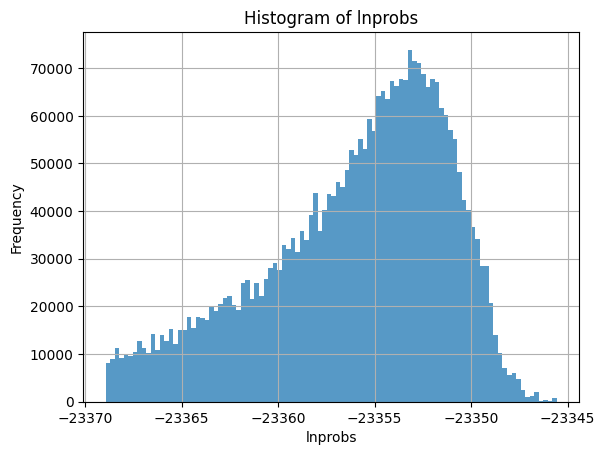

In [10]:
#plot a histogram of lnprobs2
#thresh is the threshold for lnprobs. lnprobs below thresh are not plotted
#thresh is the 95th percentile of lnprobs
thresh = np.percentile(lnprobs0, 35)
print(f"thresh: {thresh}")
# thresh =-np.inf

plt.hist(lnprobs0[lnprobs0>thresh], bins=100, alpha=0.75)
plt.xlabel('lnprobs')
plt.ylabel('Frequency')
plt.title('Histogram of lnprobs')
plt.grid(True)
plt.show()

In [11]:
if apply_thresh:
    samples_trans = samples_trans0[lnprobs0>thresh]
    lnprobs = lnprobs0[lnprobs0>thresh]

In [12]:
print(len(lnprobs))

3100500


In [13]:
sorted_samples_trans = samples_trans[np.argsort(lnprobs)]
sorted_lnprobs = np.sort(lnprobs)
#get the median values of all the parameters
p1,p2,p3,p4 = srmc.get_params_from_thetas(sorted_samples_trans)
medians_trans = [np.median(p1),np.median(p2),np.median(p3),np.median(p4)]


In [14]:
samples =np.array([srmc.inv_transform(sample) for sample in samples_trans])

In [15]:
sorted_samples = samples[np.argsort(lnprobs)]
sorted_lnprobs = np.sort(lnprobs)
#get the median values of all the parameters
etas,betas,epsilons,xcs = srmc.get_params_from_thetas(sorted_samples)
medians = [np.median(etas),np.median(betas),np.median(epsilons),np.median(xcs)]
means = [np.mean(etas),np.mean(betas),np.mean(epsilons),np.mean(xcs)]
stds = [np.std(etas),np.std(betas),np.std(epsilons),np.std(xcs)]
#calc the median deviations of the params
from scipy.stats import median_abs_deviation
medev = [median_abs_deviation(etas),median_abs_deviation(betas),median_abs_deviation(epsilons),median_abs_deviation(xcs)]



(16,)


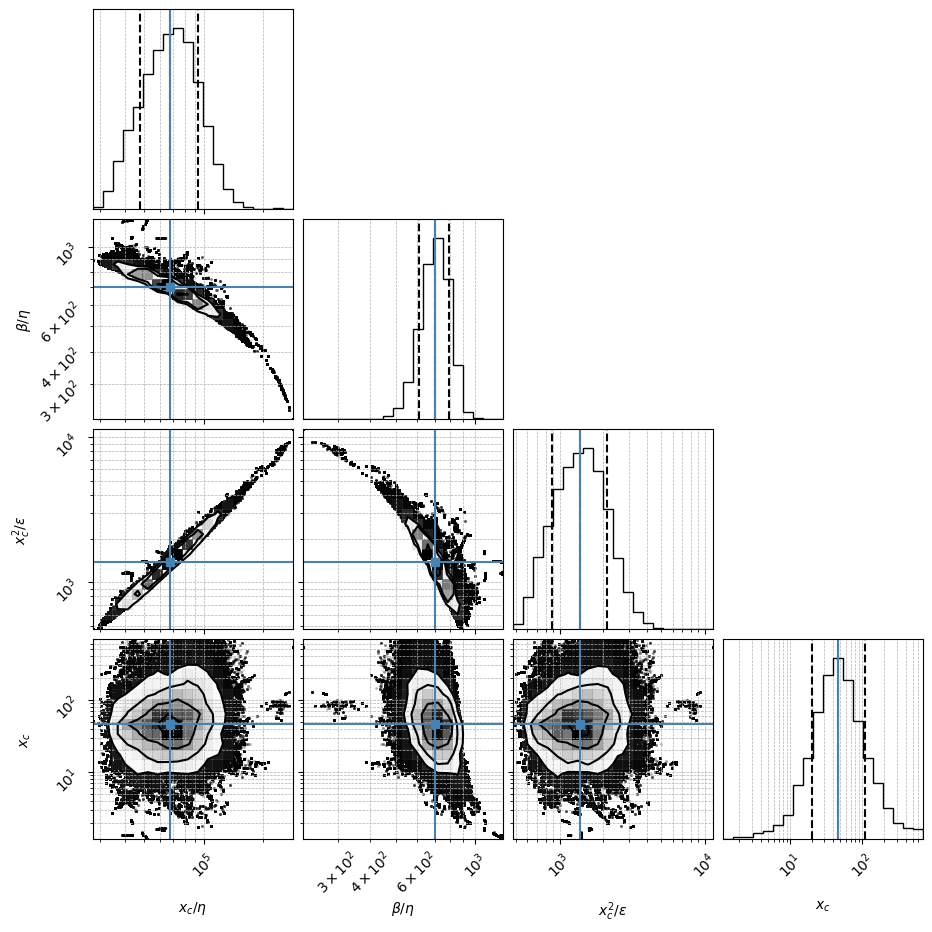

In [16]:
fig = corner.corner(samples_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=medians_trans)
axes=fig.get_axes()
print(np.shape(axes))
for ax in axes:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

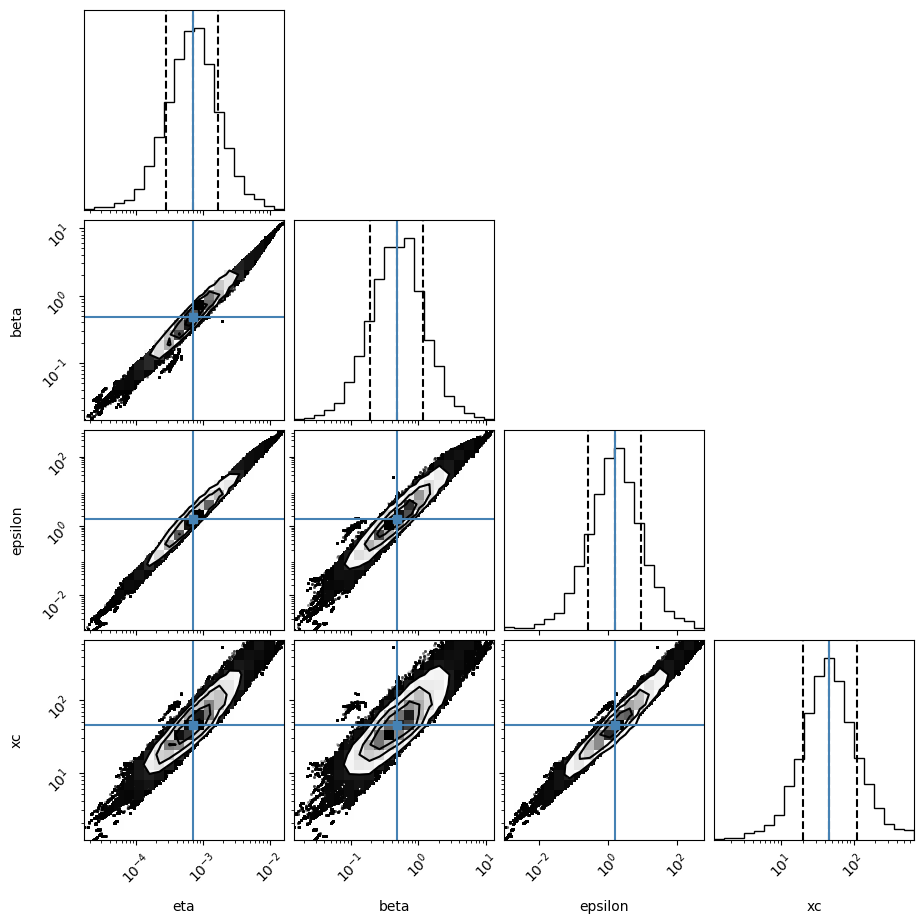

In [17]:
fig = corner.corner(samples, labels=['eta','beta','epsilon','xc'],axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=medians)

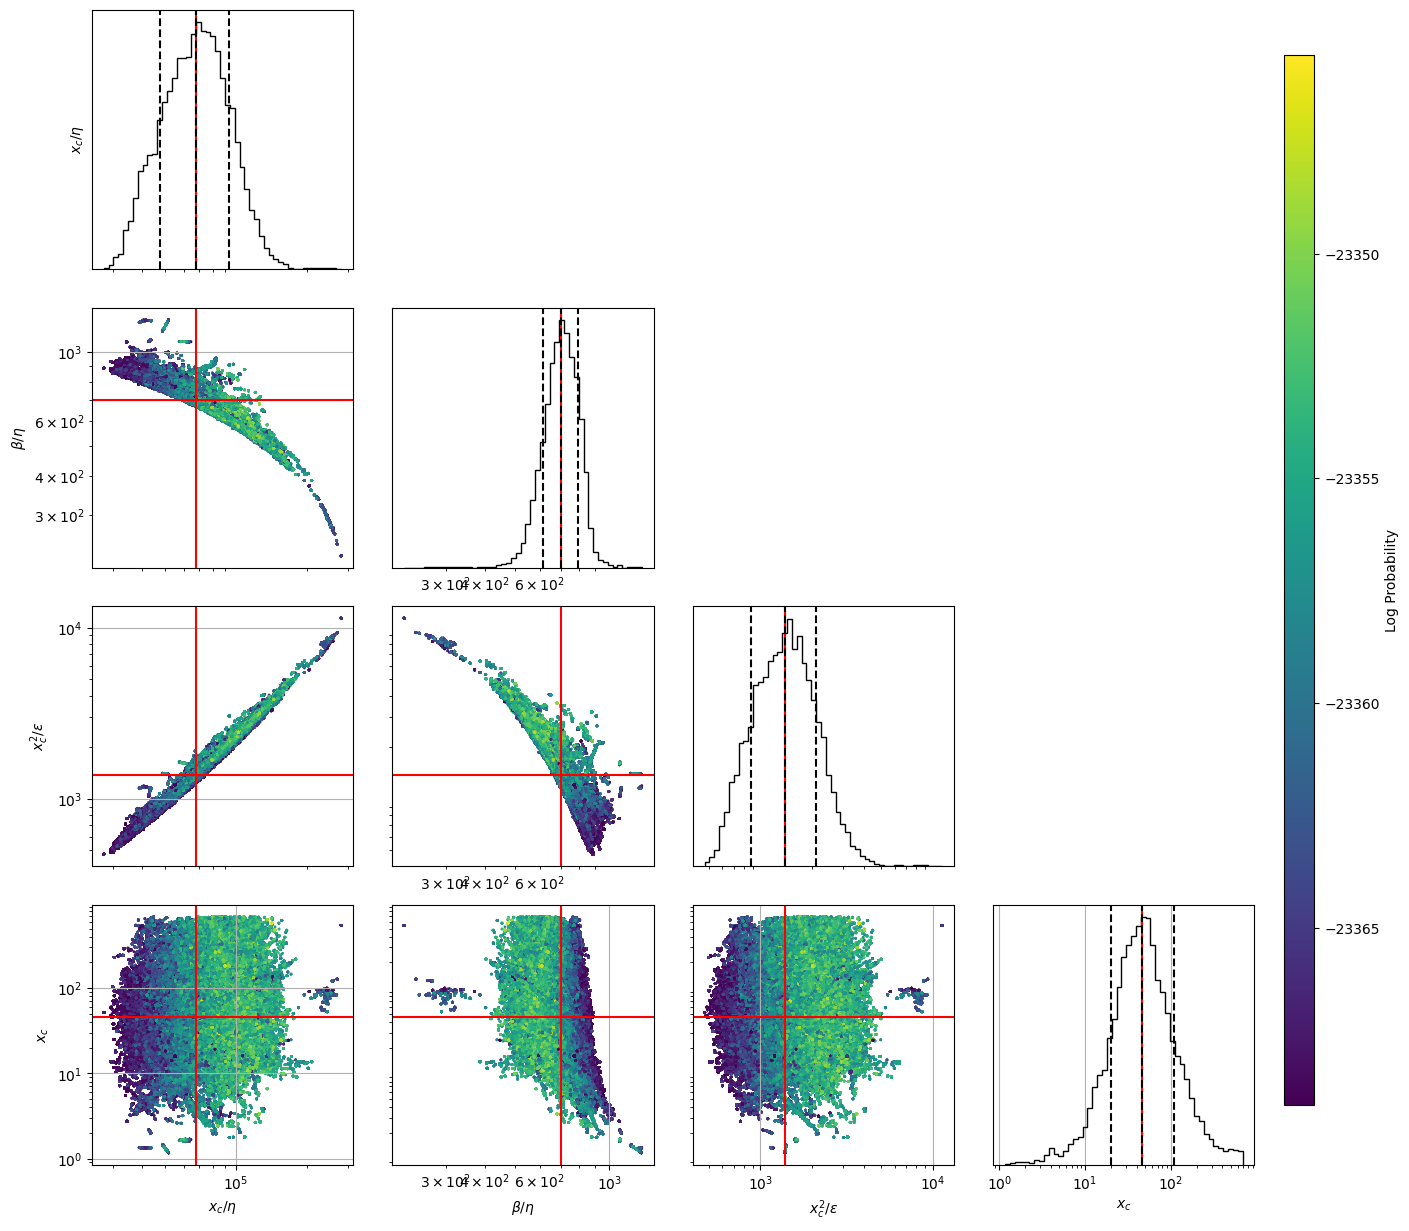

In [18]:
fig,ax=srmc.custom_corner(samples_trans,lnprobs, truths= medians_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"])

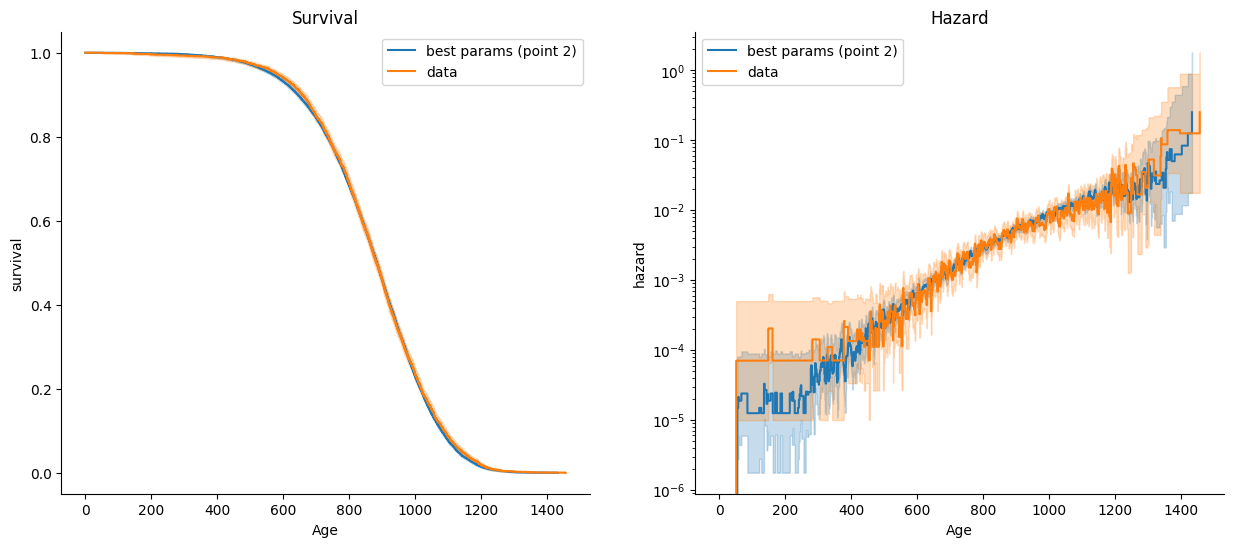

In [51]:
best_theta = sorted_samples[-1].copy()
fig, axs = plt.subplots(1, 2, figsize=(15, 6))



best_sim = srh.getSrHetro(best_theta, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard,parallel=True)


# Plot survival on ax[0]
ax0 = best_sim.plotSurvival(ax=axs[0],time_range=time_range, label='best params (point 2)', title='Survival', xlabel='time [years]', ylabel='survival')
ds.plotSurvival(ax=ax0, time_range=time_range,label='data')

# Plot hazard on ax[1]
ax1 = best_sim.plotHazard(ax=axs[1], title='Hazard', xlabel='time [years]', ylabel='hazard', label='best params (point 2)')
ds.plotHazard(ax=ax1, label='data')
ax1.set_yscale('log')

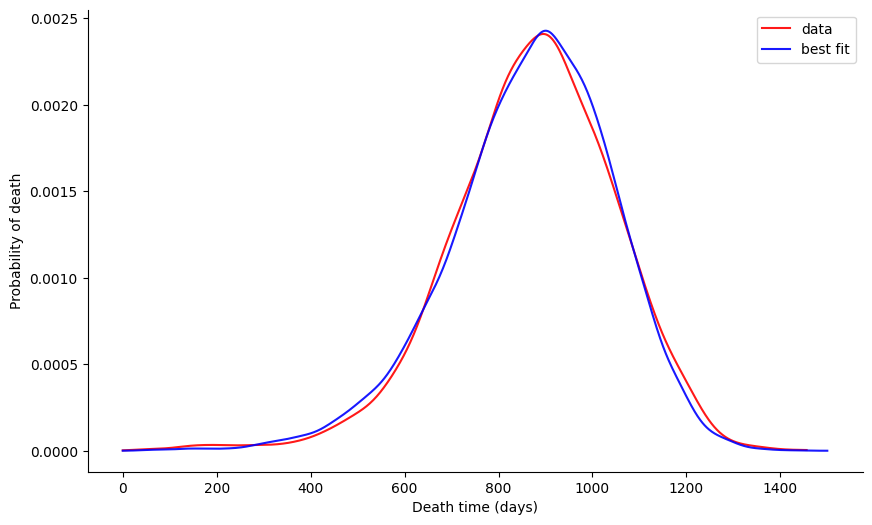

In [52]:
#add plots of the death time distributions of the best fit and data:
fig,ax = plt.subplots(1,1, figsize=(10,6))
use_kde =True

ds.plotDeathTimesDistribution(ax=ax,use_kde=use_kde ,label='data', color='r',alpha=0.9)
best_sim.plotDeathTimesDistribution(ax=ax,use_kde=use_kde, label='best fit', color='b',alpha=0.9)
ax.legend()


Averaging log-probabilities: 100%|██████████| 28943/28943 [00:00<00:00, 426812.58it/s]


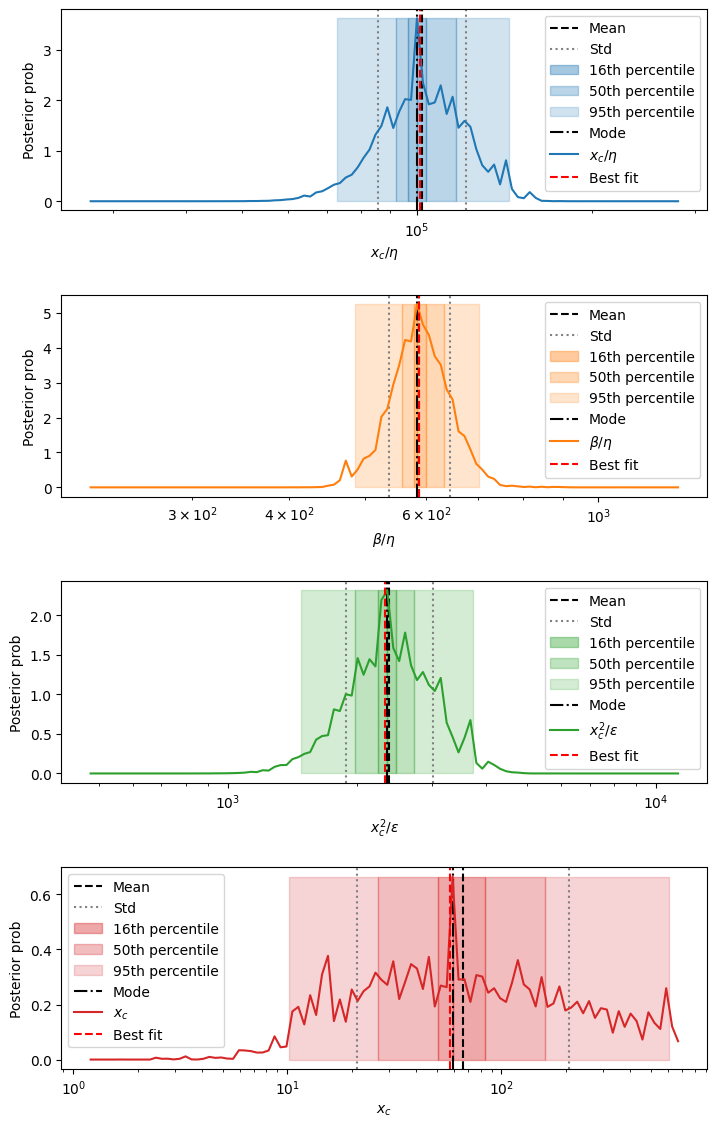

In [21]:
from SRtools import samples_utils as su
config_dict = cl.config_to_dict(config)
help_text ="help text"

post = su.Posterior(samples_trans, lnprobs, 100, log=True,config_params=config_dict,help_text=help_text)
post.plot_1d_posteriors(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], truths=sorted_samples_trans[-1],scale='log')

In [22]:
import pprint

config_dict = cl.config_to_dict(config)
help_text ="help text"
pprint.pprint(config_dict)


{'data_file': 'baysian02/datasets_baysian_01/mice_f_ds.csv',
 'external_hazard': None,
 'folder': 'baysian02/simulation_results/miceF_hetro',
 'h5_file_name': 'miceF_hetro',
 'hetro': True,
 'index': '3',
 'initial_memory': '1',
 'job_name': 'miceF',
 'max_memory': '1',
 'mcmc': 'True',
 'metric': 'baysian',
 'n_jobs': '500',
 'n_mcmc_steps': 1000,
 'name': 'miceF',
 'npeople': 20000,
 'nsteps': 5000,
 'nwalkers': 10,
 'prior': 5,
 'queue': 'short',
 'results_csv_file_name': 'Mice_F_hetro.csv',
 'run_file_mcmc': 'baysian02/run_mcmc_hetro.csh',
 'seed_file': 'baysian02/seeds_hetro01/seed_mice_F.csv',
 'submission_folder': 'baysian02/simulation_results/miceF_hetro/miceF_submit_26_05_2025',
 't_end': 1500,
 'time_range': None,
 'time_step_multiplier': 4,
 'transform': True,
 'variations': [0.2, 5]}
<class 'list'>


In [25]:

post.save_to_file(post_path)
loaded_post = su.Posterior.load_from_file(post_path)

Creating corner plot:   0%|          | 0/4 [00:00<?, ?it/s]/Users/navehr/Dropbox/naveh/weizmann/uri alon/aging/code_3/SRtools/SRtools/samples_utils.py:474: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(X, Y, Z, **kwargs)
Creating corner plot: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


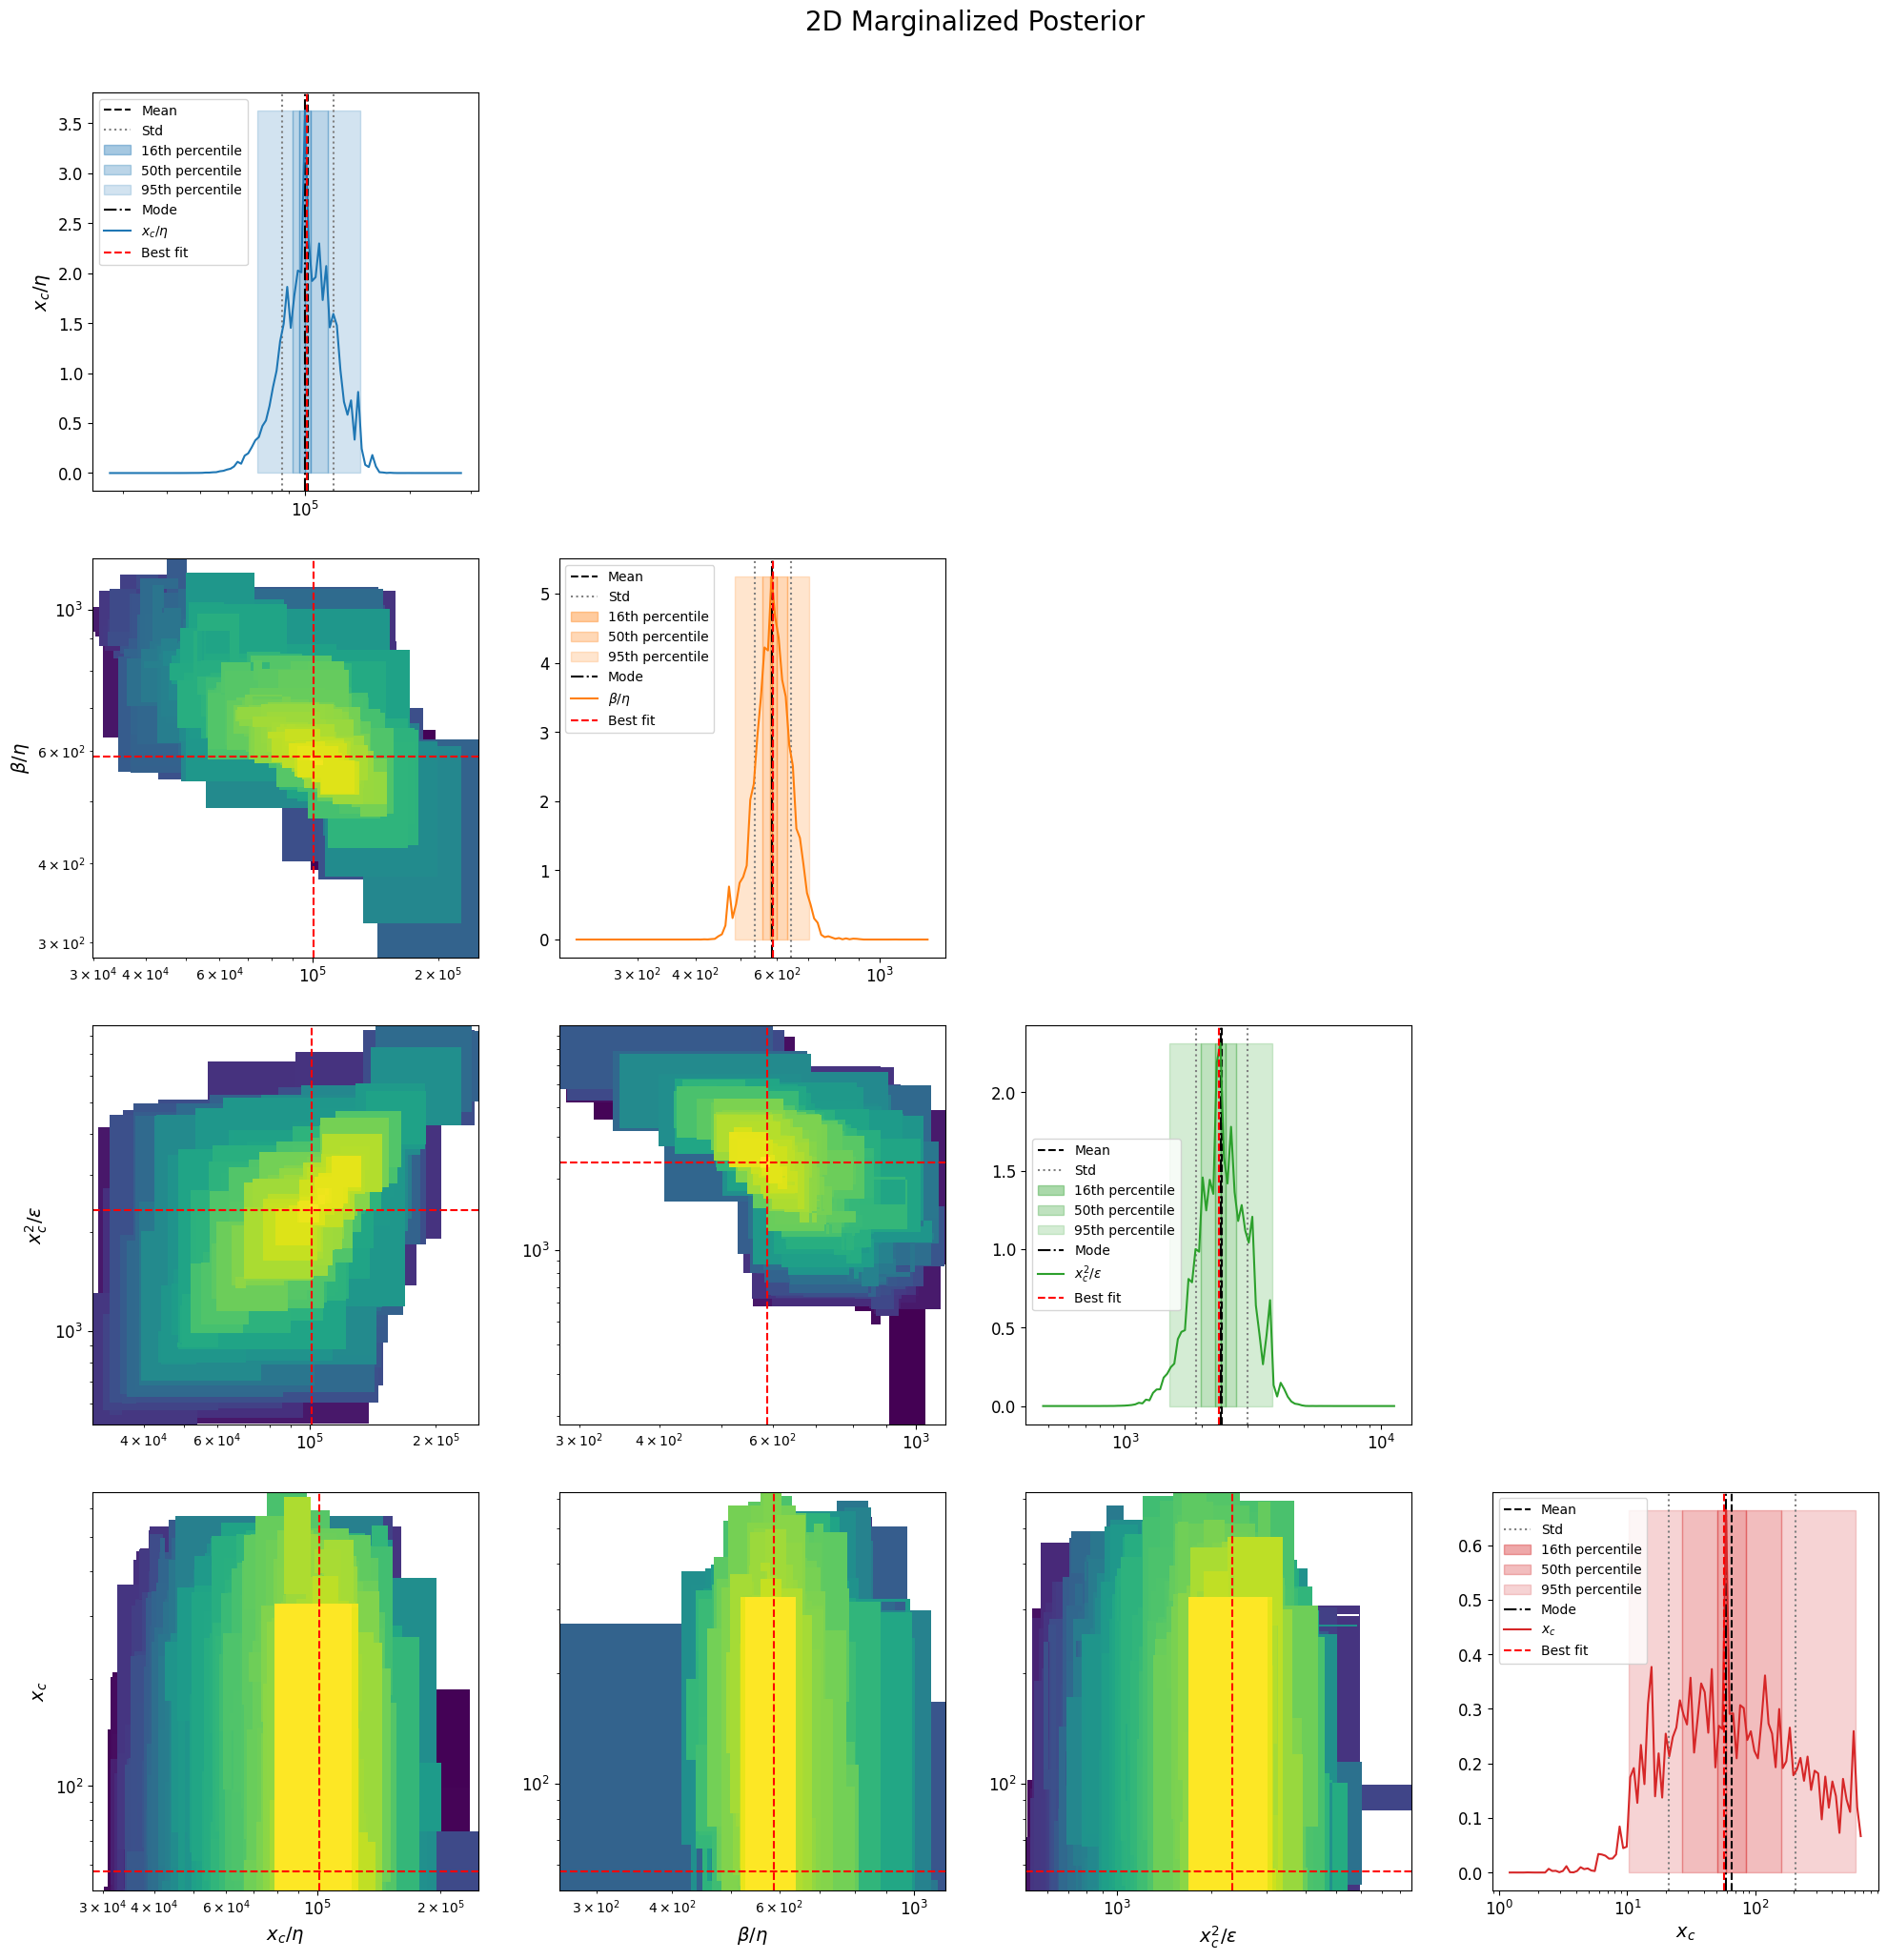

In [26]:
_=post.corner_plot(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], truths=sorted_samples_trans[-1],scale='log',show_ln_prob=False,norm='log',plot_type="pcolormesh")

In [36]:
fig =post.plot_posterior3D_interactive([0,1,2],labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","ExtH"], truths=np.log(sorted_samples_trans[-1]),truth_label="Best fit" )
# Save the figure using matplotlib's savefig instead of plotly's write_image
fig.show()

In [27]:
df=post.create_posterior_df(filepath=results_path, ds = [best_sim,ds], ds_labels=['best fit','data'])


Averaging log-probabilities: 100%|██████████| 13552/13552 [00:00<00:00, 434081.28it/s]


In [28]:
df

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood,mode_overall
xc/eta,101925.803,"[19238.098, 16183.521]",99976.149,"[98808.855, 106022.755]","[92085.796, 116467.132]","[72808.47, 143884.179]",100992.464,100992.464
beta/eta,587.794,"[55.399, 50.628]",583.927,"[578.812, 599.543]","[549.053, 621.016]","[485.429, 702.411]",588.052,588.052
xc^2/epsilon,2385.935,"[625.765, 495.744]",2359.375,"[2249.153, 2474.997]","[2043.917, 2811.787]","[1485.745, 3746.705]",2335.67,2335.67
xc,66.063,"[139.926, 44.876]",59.215,"[41.686, 69.459]","[23.472, 131.491]","[10.913, 608.27]",57.369,57.369
eta,0.000666,"[0.00182, 0.000488]",0.000534,"[0.000391, 0.000729]","[0.000183, 0.00156]","[7.97e-05, 0.00582]",0.000568,0.00406
beta,0.383,"[1.014, 0.278]",0.261,"[0.205, 0.379]","[0.0905, 0.75]","[0.0457, 3.366]",0.334,1.93
epsilon,1.96,"[25.825, 1.821]",1.392,"[0.585, 1.942]","[0.135, 9.605]","[0.0312, 157.614]",1.409,89.6
sqrt(xc/eta),315.385,"[27.496, 25.291]",316.19,"[310.669, 321.81]","[296.412, 333.35]","[266.68, 370.515]",317.793,317.793
s= eta^0.5*xc^1.5/epsilon,7.303,"[1.128, 0.977]",7.241,"[7.024, 7.465]","[6.609, 8.097]","[5.505, 9.72]",7.35,7.35
beta*xc/epsilon,13.755,"[0.79, 0.747]",13.568,"[13.466, 13.876]","[13.068, 14.086]","[12.493, 15.412]",13.6,13.6


In [53]:
#get the theta of the modes of the posterior (from the df) location of indexes eta, beta, epsilon, xc and columen 'mode'
theta_mode =  df.loc[['eta','beta','epsilon','xc'],'mode'].values
print(f"theta_mode: {theta_mode}")
theta_mode_trans =  post.get_best_sample_in_mode()
print(f"theta_mode_trans: {theta_mode_trans}")
sim_mode = srh.getSrHetro(theta_mode, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard)
sim_mode_trans = srh.getSrHetro(srmc.inv_transform(theta_mode_trans), nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard)


theta_mode: [0.000534 0.261 1.392 59.215]
theta_mode_trans: [1.00992464e+05 5.88052042e+02 2.33566952e+03 5.73694728e+01]


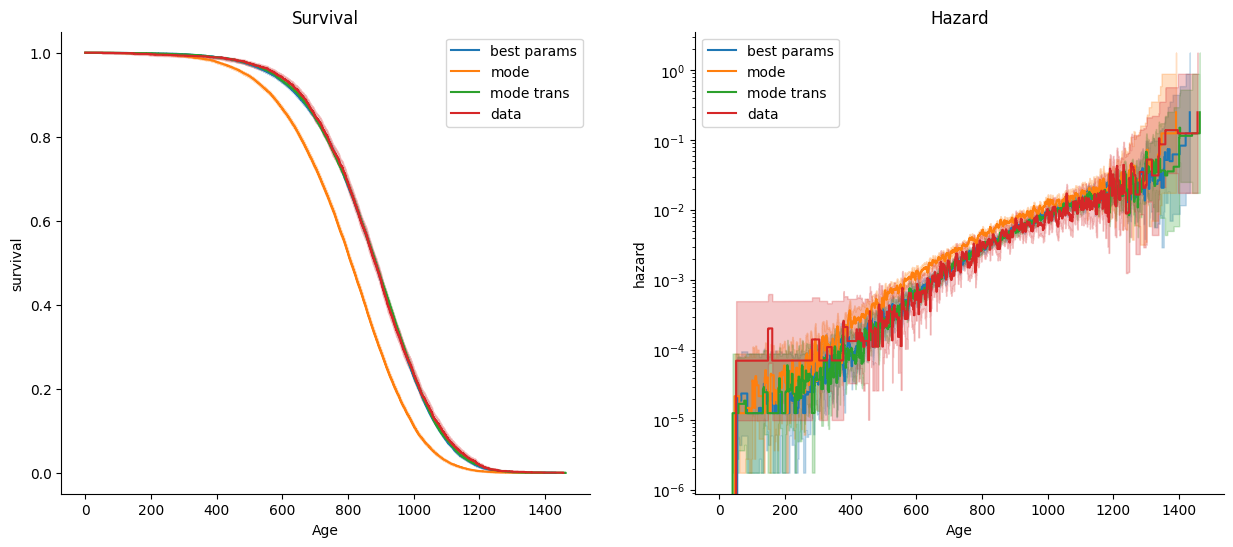

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot survival on ax[0]
ax0 = best_sim.plotSurvival(ax=axs[0],time_range=time_range, label='best params', title='Survival', xlabel='time [years]', ylabel='survival')
sim_mode.plotSurvival(ax=ax0,time_range=time_range, label='mode')
sim_mode_trans.plotSurvival(ax=ax0,time_range=time_range, label='mode trans')
ds.plotSurvival(ax=ax0,time_range=time_range, label='data')
ax0.legend()

# Plot hazard on ax[1]
ax1 = best_sim.plotHazard(ax=axs[1], title='Hazard', xlabel='time [years]', ylabel='hazard', label='best params')
sim_mode.plotHazard(ax=ax1, label='mode')
sim_mode_trans.plotHazard(ax=ax1, label='mode trans')
ds.plotHazard(ax=ax1, label='data')
ax1.set_yscale('log')

Averaging log-probabilities: 100%|██████████| 7773/7773 [00:00<00:00, 420979.35it/s]


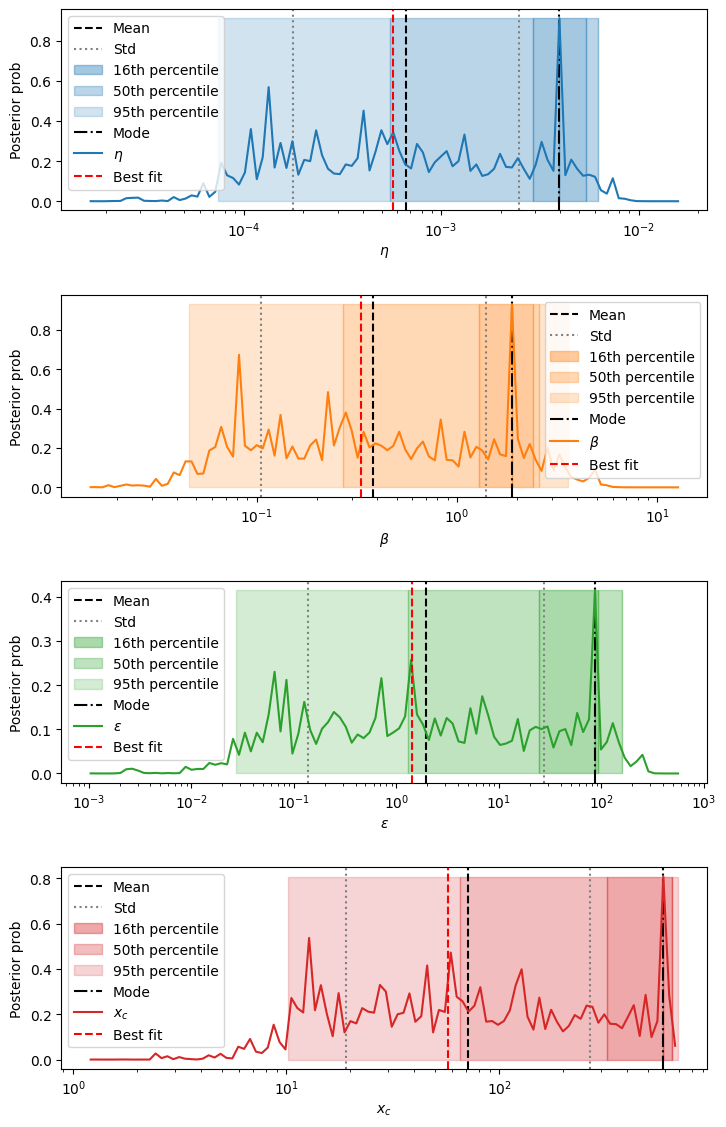

In [55]:
post_regular_params = su.Posterior(samples, lnprobs, 100, log=True)
post_regular_params.plot_1d_posteriors(labels=["$\\eta$","$\\beta$","$\\epsilon$","$x_c$"], truths=sorted_samples[-1],scale='log')